In [1]:
import pandas as pd
import numpy as np
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
#!pip install mysql-connector-python

# Vehicle CO2 Emission Prediction Model

In this project, I try to predict CO2 emissions based on our vehicle data we got from the enviromental protection agency (EPA).
Link to data: https://www.epa.gov/automotive-trends/explore-automotive-trends-data

I want to find the relationship in different variables to see how it affects CO2 emissions. Hopefully this research shows us what the leading indicators for higher emissions  is, so we can limit it as much as possible.

Just a note on the data, I didn't use the full dataset that was provided to me because a lot of columns had missing information. We had rows of missing data for certain years that would be very hard to fill so I took those out. I also saw that a lot of the columns were not useful and incomplete so I decided not to use those. The dataset orginialy contained about 5.4K rows but after taking out the rows, I was left with 4.2K.

Here are the steps I took to get our model running:

1. Insert data into MySQL Database to be able to query at anytime and keep data safe.
2. Clean data for EDA and model.
3. Do exploratory data analysis to get a better understanding of our dataset.
4. Prepare dataset for model prediction.
5. Use both linear regression and random forest models.

### Connecting to MySQL
I connected this Juypter Notebook to MySQL and created a dataframe. I have previously loaded the data in MySQL, please see the SQL portion of this project if you are interested. 

In [2]:
# Establish a connection to the MySQL database
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="goodreads"
)

cursor = conn.cursor()

# Execute a query
#cursor.execute(f"SELECT book_avg_score.Title, Categories FROM book_avg_score INNER JOIN book_categories ON book_avg_score.Title = book_categories.Title WHERE avg_review_score>={score_above} AND Categories LIKE '%{user_category}%';")
cursor.execute("SELECT Manufacturer, ModelYear, RegulatoryClass, VehicleType, TwoCycleMPG, RealWorldMPG, RealWorldMPG_City, RealWorldMPG_Hwy, RealWorldCO2, RealWorldCO2_City, RealWorldCO2_Hwy,  Weight   FROM vehicledata;")

# Fetch and print the results
results = cursor.fetchall()

# Create a DataFrame
df = pd.DataFrame(results, columns=[desc[0] for desc in cursor.description])

cursor.close()
conn.close()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Manufacturer       4076 non-null   object
 1   ModelYear          4076 non-null   object
 2   RegulatoryClass    4076 non-null   object
 3   VehicleType        4076 non-null   object
 4   TwoCycleMPG        4076 non-null   object
 5   RealWorldMPG       4076 non-null   object
 6   RealWorldMPG_City  4076 non-null   object
 7   RealWorldMPG_Hwy   4076 non-null   object
 8   RealWorldCO2       4076 non-null   object
 9   RealWorldCO2_City  4076 non-null   object
 10  RealWorldCO2_Hwy   4076 non-null   object
 11  Weight             4076 non-null   object
dtypes: object(12)
memory usage: 382.2+ KB


In [4]:
df.head()

,Manufacturer,ModelYear,RegulatoryClass,VehicleType,TwoCycleMPG,RealWorldMPG,RealWorldMPG_City,RealWorldMPG_Hwy,RealWorldCO2,RealWorldCO2_City,RealWorldCO2_Hwy,Weight
0,Mazda,2014,Car,Sedan/Wagon,42.43035,32.22340,27.54713,36.95602,275.79339,322.61074,240.47504,3138.768
1,Mazda,2015,Car,Sedan/Wagon,42.87430,32.58697,27.66540,37.63808,272.71639,321.23156,236.11723,3185.374
2,Mazda,2016,Car,Sedan/Wagon,42.85413,32.48981,27.81107,37.21254,273.53195,319.54899,238.81734,3123.836
3,Mazda,2017,Car,Sedan/Wagon,40.84889,31.45438,26.92042,36.03245,282.53621,330.12116,246.63879,3205.841
4,Mazda,2018,Car,Sedan/Wagon,40.21866,30.90383,26.41161,35.45276,287.56952,336.48076,250.67157,3383.682


## Clean Dataframe
We need to clean some columns so that we can use our data effectively and accurately. Once that is done, I need to turn the data types into integers.

In [5]:
df['ModelYear'] = df['ModelYear'].str.replace('Prelim. 2022', '2022')

<ipython-input-5-972a22023f0d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['ModelYear'] = df['ModelYear'].str.replace('Prelim. 2022', '2022')


In [6]:
df['ModelYear'] = df['ModelYear'].astype(float)
df['TwoCycleMPG'] = df['TwoCycleMPG'].astype(float)
df['RealWorldMPG'] = df['RealWorldMPG'].astype(float)
df['RealWorldMPG_City'] = df['RealWorldMPG_City'].astype(float)
df['RealWorldMPG_Hwy'] = df['RealWorldMPG_Hwy'].astype(float)
df['RealWorldCO2'] = df['RealWorldCO2'].astype(float)

In [7]:
df[df['RealWorldCO2_City']=='1,110.60293']

,Manufacturer,ModelYear,RegulatoryClass,VehicleType,TwoCycleMPG,RealWorldMPG,RealWorldMPG_City,RealWorldMPG_Hwy,RealWorldCO2,RealWorldCO2_City,RealWorldCO2_Hwy,Weight
439,Toyota,1976.0,Car,Car SUV,10.74608,9.19707,8.00196,11.25082,966.28564,"1,110.60293",789.89785,4000.000


In [8]:
df['RealWorldCO2_City'] = df['RealWorldCO2_City'].str.replace(',', '')

In [9]:
df['RealWorldCO2_City'] = df['RealWorldCO2_City'].astype(float)
df['RealWorldCO2_Hwy'] = df['RealWorldCO2_Hwy'].astype(float)
df['Weight'] = df['Weight'].astype(float)

I want to see how each column correlates with RealWorldC02. I will use this information to pick which columns are the most important in our model. Their is high correlation in RealWorldC02_City and RealWorldC02_Highway because those numbers we're derived in creating RealWorldC02. I also see a negative correlation with RealWorldMPG, which means that a higher MPG would mean lower CO2 emissions.

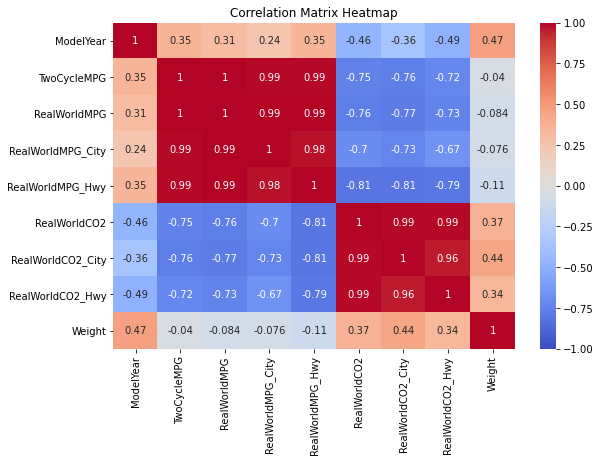

In [10]:
correlation_matrix = df.corr()
# Create a heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Exploratory Data Analysis
We will now explore our dataset more closely to see if we can find any notable trends and insights.

In [11]:
df.describe()

,ModelYear,TwoCycleMPG,RealWorldMPG,RealWorldMPG_City,RealWorldMPG_Hwy,RealWorldCO2,RealWorldCO2_City,RealWorldCO2_Hwy,Weight
count,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000
mean,2000.779441,28.072403,22.597362,19.969450,25.607860,425.942527,485.142937,374.120592,3819.585404
std,13.608647,14.145703,10.300872,10.613666,10.154930,107.565685,116.641831,99.090872,699.366393
min,1975.000000,10.587320,8.994720,8.001960,9.588200,0.000000,0.000000,0.000000,2000.000000
25%,1990.000000,22.347152,18.332650,16.056742,20.875757,359.874188,413.025830,315.145940,3361.138000
50%,2002.000000,26.673625,21.695250,18.748740,24.892825,410.683325,474.499485,357.683675,3781.604500
75%,2013.000000,30.301572,24.693430,21.541100,28.202840,486.228180,554.431263,426.346465,4306.371500
max,2022.000000,176.245670,129.831470,137.749320,124.435660,988.023890,1110.602930,926.868380,6668.898000


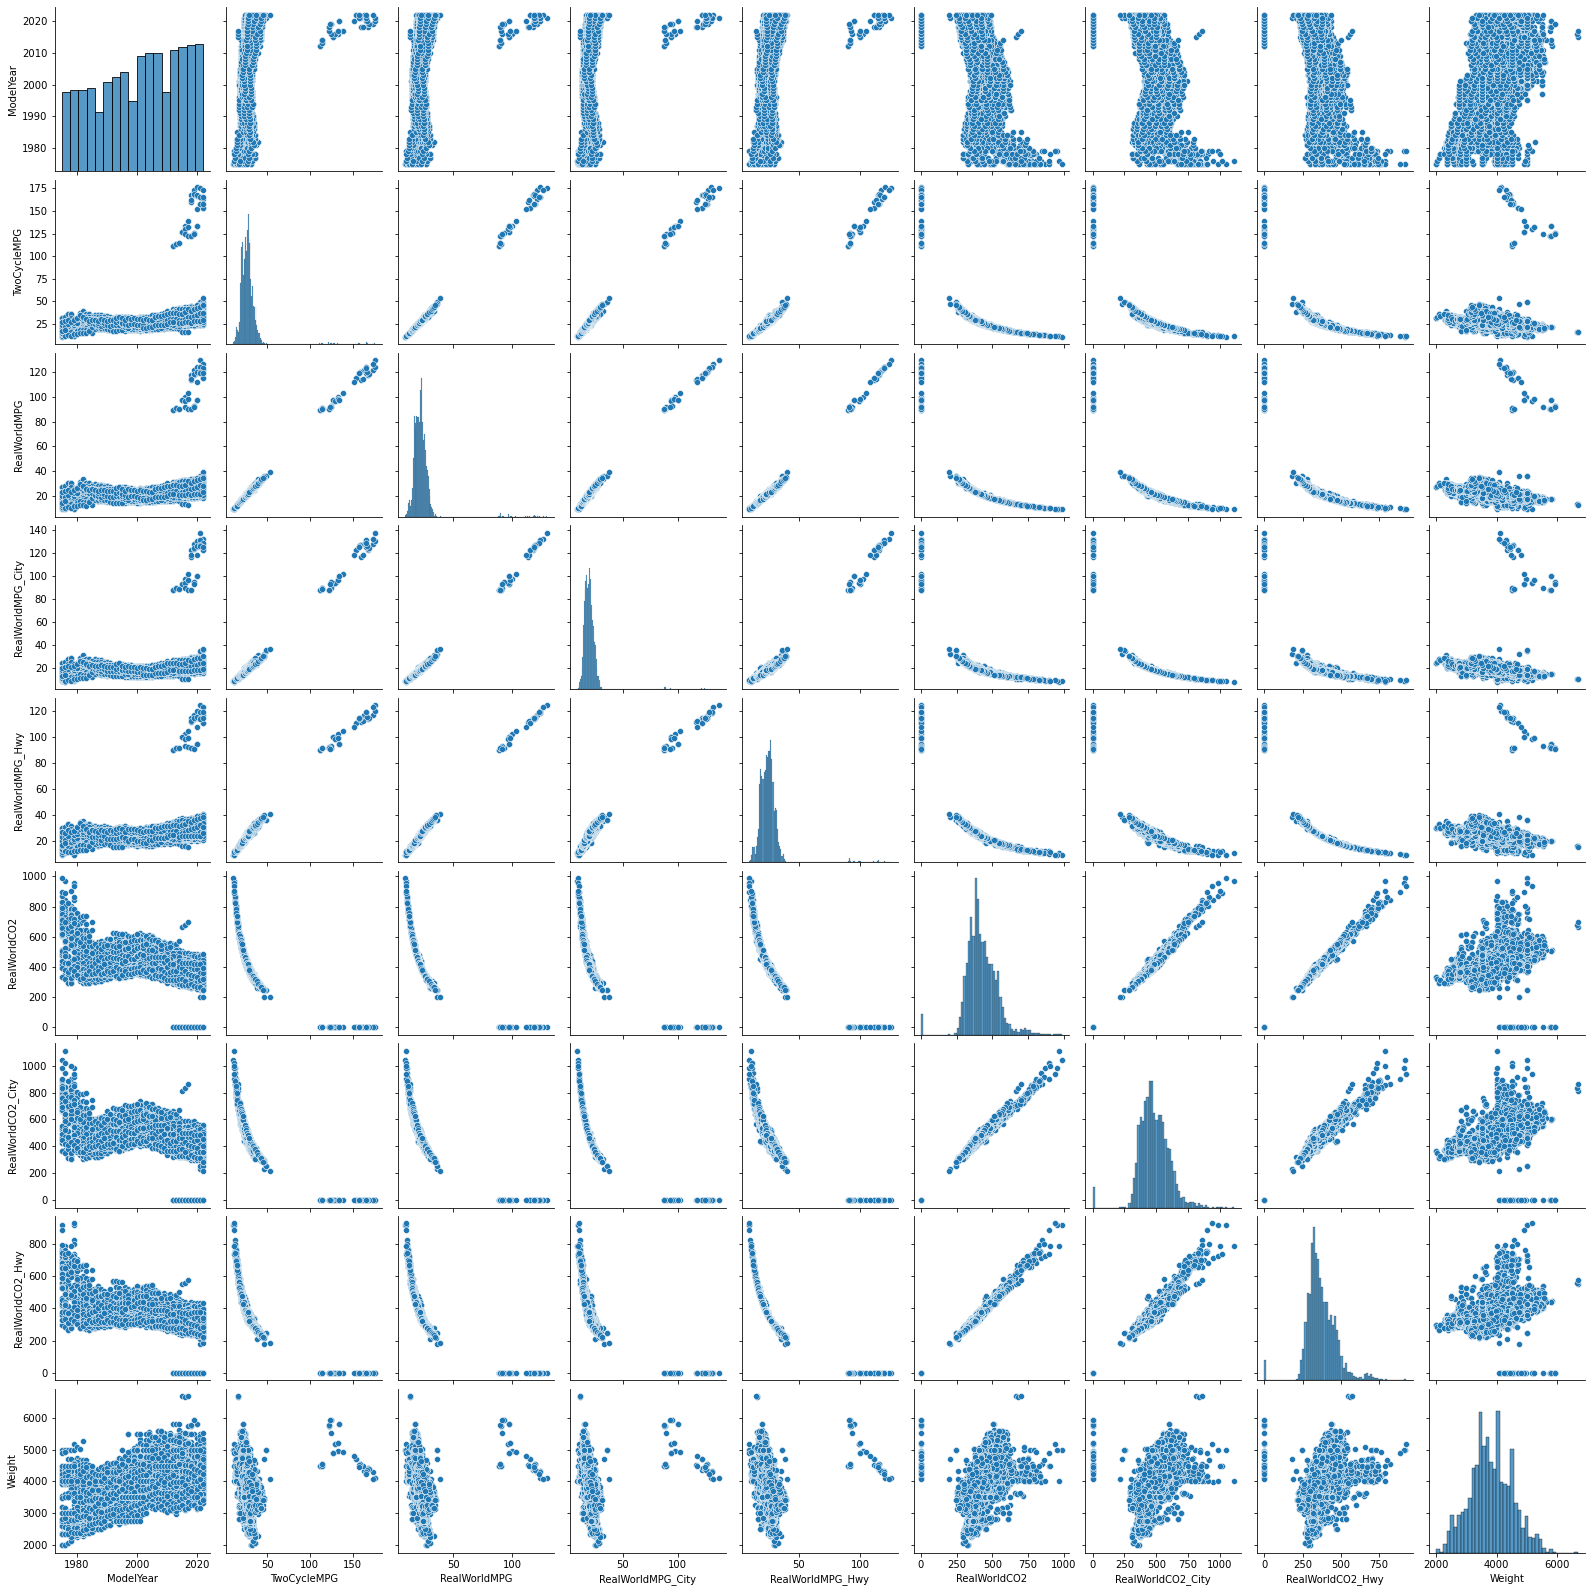

In [12]:
sns.pairplot(df)
plt.show()

## Take Out Aggregated Data
I am seeing that we have areas in our data that have 0 CO2 emissions and splotches of data that are clustered together. After some investigation, I saw that Tesla was emitting 0 CO2 emissions because it's an electric vehicle. I also saw that we had aggregated data which should not be included in our analysis. So I will take those out.

In [13]:
df[["Manufacturer"]].value_counts()

Manufacturer
All             384
Stellantis      382
GM              376
Ford            373
Toyota          363
Nissan          332
Mazda           297
Honda           272
VW              249
Subaru          218
Mercedes        214
BMW             197
Kia             192
Hyundai         177
Tesla            50
dtype: int64

In [14]:
df.drop(df[df['Manufacturer'] == 'All'].index, inplace=True)

In [15]:
df[["RegulatoryClass"]].value_counts()

RegulatoryClass
Truck              1549
Car                1537
All                 606
dtype: int64

In [16]:
df.drop(df[df['RegulatoryClass'] == 'All'].index, inplace=True)

In [17]:
df[["VehicleType"]].value_counts()

VehicleType
All Car        606
Sedan/Wagon    606
All Truck      499
Truck SUV      429
Car SUV        325
Minivan/Van    316
Pickup         305
dtype: int64

In [18]:
df.drop(df[df['VehicleType'] == 'All Car'].index, inplace=True)
df.drop(df[df['VehicleType'] == 'All Truck'].index, inplace=True)
df.drop(df[df['Manufacturer'] == 'Tesla'].index, inplace=True)

## Plotting Data

We will now start plotting our data so that we can visualize our data and find any relationships. The most important columns I want to see are the Manufacturer, RealWorldCO2, RealWorldMPG, Vehicle Type, and Weight.

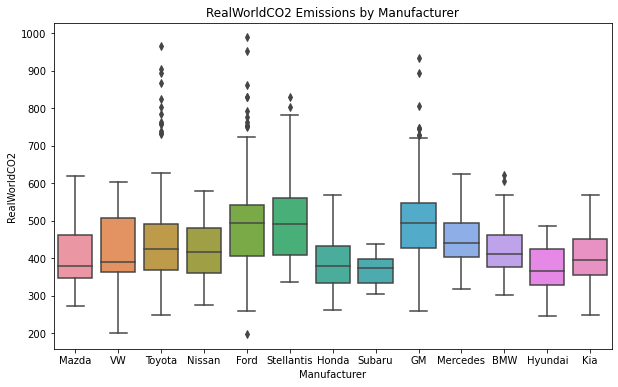

In [19]:
filtered_df = df.query('Manufacturer != "Tesla"')
plt.figure(figsize=(10, 6))
sns.boxplot(x='Manufacturer', y='RealWorldCO2', data=filtered_df)

plt.xlabel('Manufacturer')
plt.ylabel('RealWorldCO2')
plt.title('RealWorldCO2 Emissions by Manufacturer')

plt.show()

Seeing Toyota have splotches of data that have high CO2 emissions is interesting. I believe this is because older models tended to emit higher emissions. I am not too suprised at Ford and GM because they produce bigger and heavier trucks, which would mean higher emissions. 

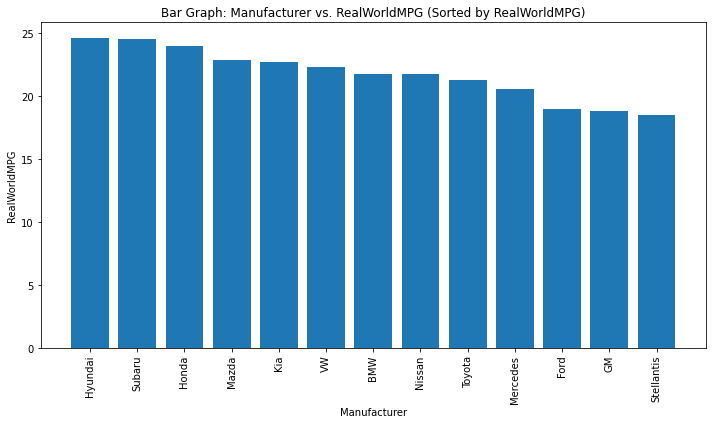

In [20]:
filtered_df = df.query('Manufacturer != "Tesla"')
grouped_data = filtered_df.groupby('Manufacturer')['RealWorldMPG'].mean().reset_index()
manufacture_data = grouped_data['Manufacturer']
RealWorldMPG = grouped_data['RealWorldMPG']

# Sort the data by 'RealWorldC02' column in descending order
sorted_df = grouped_data.sort_values(by='RealWorldMPG', ascending=False)

# Create the bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
plt.bar(sorted_df['Manufacturer'], sorted_df['RealWorldMPG'])
plt.xlabel('Manufacturer')
plt.ylabel('RealWorldMPG')
plt.title('Bar Graph: Manufacturer vs. RealWorldMPG (Sorted by RealWorldMPG)')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed for better visibility
plt.tight_layout()  # Adjust spacing to avoid overlapping labels
plt.show()

The average MPG is higher for compact cars like Hyundai, Subaru and Honda. Which I expected to see in our data.

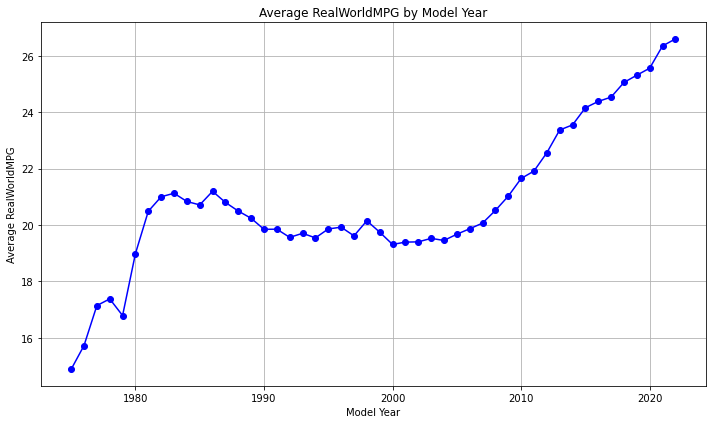

In [21]:
filtered_df = df.query('Manufacturer != "Tesla"')
grouped_data = filtered_df.groupby('ModelYear')['RealWorldMPG'].mean().reset_index()

# Extract the 'ModelYear' and 'RealWorldC02' columns after averaging
model_year = grouped_data['ModelYear']
RealWorldMPG_avg = grouped_data['RealWorldMPG']

# Create the line graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
plt.plot(model_year, RealWorldMPG_avg, marker='o', linestyle='-', color='b')
plt.xlabel('Model Year')
plt.ylabel('Average RealWorldMPG')
plt.title('Average RealWorldMPG by Model Year')
plt.grid(True)  # Add gridlines for better readability
plt.tight_layout()  # Adjust spacing to avoid overlapping labels
plt.show()

We see that MPG increaeses overtime. This is a great indication that new technology has helped us become more efficent at utilizing fuel.

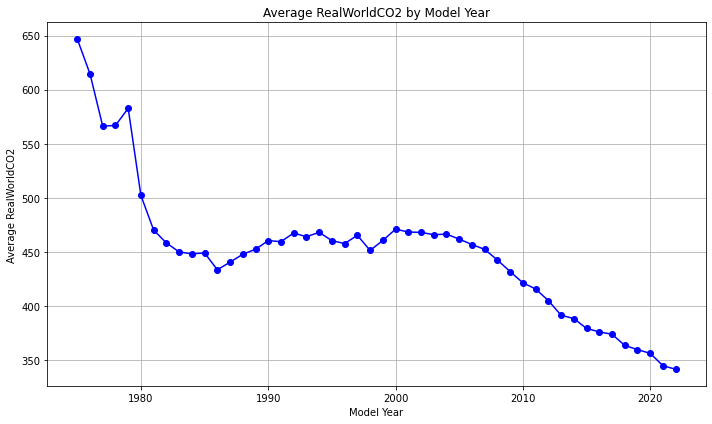

In [22]:
filtered_df = df.query('Manufacturer != "Tesla"')
grouped_data = filtered_df.groupby('ModelYear')['RealWorldCO2'].mean().reset_index()

# Extract the 'ModelYear' and 'RealWorldC02' columns after averaging
model_year = grouped_data['ModelYear']
real_world_c02_avg = grouped_data['RealWorldCO2']

# Create the line graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
plt.plot(model_year, real_world_c02_avg, marker='o', linestyle='-', color='b')
plt.xlabel('Model Year')
plt.ylabel('Average RealWorldCO2')
plt.title('Average RealWorldCO2 by Model Year')
plt.grid(True)  # Add gridlines for better readability
plt.tight_layout()  # Adjust spacing to avoid overlapping labels
plt.show()

We also see that CO2 emissions are falling overtime. Which is great for the enviroment!

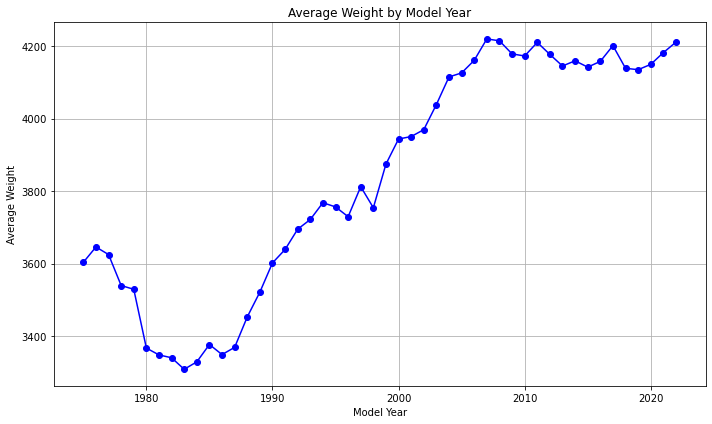

In [23]:
filtered_df = df.query('Manufacturer != "Tesla"')
grouped_data = filtered_df.groupby('ModelYear')['Weight'].mean().reset_index()

# Extract the 'ModelYear' and 'RealWorldC02' columns after averaging
model_year = grouped_data['ModelYear']
Weight_avg = grouped_data['Weight']

# Create the line graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
plt.plot(model_year, Weight_avg, marker='o', linestyle='-', color='b')
plt.xlabel('Model Year')
plt.ylabel('Average Weight')
plt.title('Average Weight by Model Year')
plt.grid(True)  # Add gridlines for better readability
plt.tight_layout()  # Adjust spacing to avoid overlapping labels
plt.show()

Very interesting that the weight of cars have reached a peak at the end of 2000s. I would assume that higher weight would mean worse emissions and MPG, but from the previous graphs, we see the opposite.

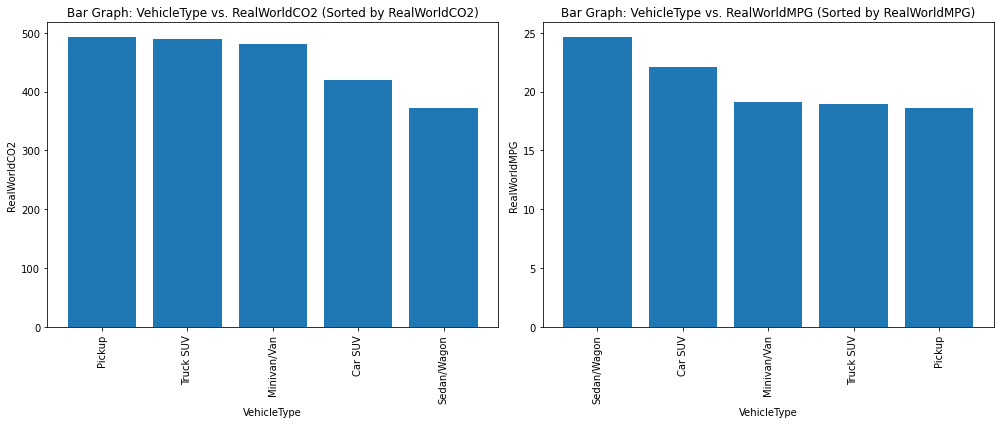

In [24]:
filtered_df = df.query('Manufacturer != "Tesla"')
grouped_data2 = filtered_df.groupby('VehicleType')['RealWorldMPG'].mean().reset_index()
grouped_data = filtered_df.groupby('VehicleType')['RealWorldCO2'].mean().reset_index()
sorted_df2 = grouped_data2.sort_values(by='RealWorldMPG', ascending=False)
sorted_df = grouped_data.sort_values(by='RealWorldCO2', ascending=False)

# Create the first bar graph
plt.figure(figsize=(14, 6))  # Adjust the figure size as per your preference

# First subplot (left)
plt.subplot(1, 2, 1)
plt.bar(sorted_df['VehicleType'], sorted_df['RealWorldCO2'])
plt.xlabel('VehicleType')
plt.ylabel('RealWorldCO2')
plt.title('Bar Graph: VehicleType vs. RealWorldCO2 (Sorted by RealWorldCO2)')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed for better visibility

# Create the second bar graph
# Second subplot (right)
plt.subplot(1, 2, 2)
plt.bar(sorted_df2['VehicleType'], sorted_df2['RealWorldMPG'])
plt.xlabel('VehicleType')
plt.ylabel('RealWorldMPG')
plt.title('Bar Graph: VehicleType vs. RealWorldMPG (Sorted by RealWorldMPG)')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed for better visibility

plt.tight_layout()  # Adjust spacing to avoid overlapping labels
plt.show()


Heavier cars tend to have higher CO2 emissions and MPG is higher for smaller cars.

## Hot Encoding

We will now transform our data to get it ready to fit the model. We will start by hot encoding our categorical data. In this case I use VehicleType because it has a good amount of different types of cars. The other classes either have too many different categories or not enough which is the case for Manufacturer and RegulatoryClass. We hot encode so that our model will produce accurate results as it takes in numbers much better than categories.

In [25]:
# One-hot encode the 'Category' column
one_hot_encoded = pd.get_dummies(df['VehicleType'])

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df, one_hot_encoded], axis=1)

In [26]:
df_encoded

,Manufacturer,ModelYear,RegulatoryClass,VehicleType,TwoCycleMPG,RealWorldMPG,RealWorldMPG_City,RealWorldMPG_Hwy,RealWorldCO2,RealWorldCO2_City,RealWorldCO2_Hwy,Weight,Car SUV,Minivan/Van,Pickup,Sedan/Wagon,Truck SUV
0,Mazda,2014.0,Car,Sedan/Wagon,42.43035,32.22340,27.54713,36.95602,275.79339,322.61074,240.47504,3138.768,0,0,0,1,0
1,Mazda,2015.0,Car,Sedan/Wagon,42.87430,32.58697,27.66540,37.63808,272.71639,321.23156,236.11723,3185.374,0,0,0,1,0
2,Mazda,2016.0,Car,Sedan/Wagon,42.85413,32.48981,27.81107,37.21254,273.53195,319.54899,238.81734,3123.836,0,0,0,1,0
3,Mazda,2017.0,Car,Sedan/Wagon,40.84889,31.45438,26.92042,36.03245,282.53621,330.12116,246.63879,3205.841,0,0,0,1,0
4,Mazda,2018.0,Car,Sedan/Wagon,40.21866,30.90383,26.41161,35.45276,287.56952,336.48076,250.67157,3383.682,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,Kia,2018.0,Car,Sedan/Wagon,39.41305,30.60687,26.42119,34.76121,289.76888,335.61170,255.18571,3266.920,0,0,0,1,0
4038,Kia,2019.0,Car,Sedan/Wagon,41.26756,31.91637,27.74728,35.99652,276.85203,318.54354,245.40053,3259.794,0,0,0,1,0
4039,Kia,2020.0,Car,Sedan/Wagon,42.69637,32.81806,28.54696,36.99346,269.26247,309.73848,238.72795,3165.082,0,0,0,1,0
4040,Kia,2021.0,Car,Sedan/Wagon,43.29126,33.37512,28.60089,38.18343,265.85022,310.29355,232.32279,3170.214,0,0,0,1,0


In [27]:
df_encoded.drop(columns=['Manufacturer', 'RegulatoryClass', 'VehicleType'], inplace=True)

In [28]:
df_encoded

,ModelYear,TwoCycleMPG,RealWorldMPG,RealWorldMPG_City,RealWorldMPG_Hwy,RealWorldCO2,RealWorldCO2_City,RealWorldCO2_Hwy,Weight,Car SUV,Minivan/Van,Pickup,Sedan/Wagon,Truck SUV
0,2014.0,42.43035,32.22340,27.54713,36.95602,275.79339,322.61074,240.47504,3138.768,0,0,0,1,0
1,2015.0,42.87430,32.58697,27.66540,37.63808,272.71639,321.23156,236.11723,3185.374,0,0,0,1,0
2,2016.0,42.85413,32.48981,27.81107,37.21254,273.53195,319.54899,238.81734,3123.836,0,0,0,1,0
3,2017.0,40.84889,31.45438,26.92042,36.03245,282.53621,330.12116,246.63879,3205.841,0,0,0,1,0
4,2018.0,40.21866,30.90383,26.41161,35.45276,287.56952,336.48076,250.67157,3383.682,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,2018.0,39.41305,30.60687,26.42119,34.76121,289.76888,335.61170,255.18571,3266.920,0,0,0,1,0
4038,2019.0,41.26756,31.91637,27.74728,35.99652,276.85203,318.54354,245.40053,3259.794,0,0,0,1,0
4039,2020.0,42.69637,32.81806,28.54696,36.99346,269.26247,309.73848,238.72795,3165.082,0,0,0,1,0
4040,2021.0,43.29126,33.37512,28.60089,38.18343,265.85022,310.29355,232.32279,3170.214,0,0,0,1,0


## Linear Regression

We will start off with a linear regression as this should be able to assimiliate the data well enough to be able to predict CO2 emissions. I chose this model because their is a negative relationship between RealWorldCO2 and RealWorldMPG. Just a note, I didn't use RealWorld CO2_City and RealWorldCO2_Hwy since that data is derived in RealWorldCO2.

In [29]:
scaler = StandardScaler()

# Fit and transform the data using the StandardScaler
normalized_data = scaler.fit_transform(df_encoded)

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=df_encoded.columns)

In [30]:
# Split the data into features (X) and target (y)
X = normalized_df.drop(columns=['RealWorldCO2', 'RealWorldCO2_City', 'RealWorldCO2_Hwy'])  # Features: Feature2
y = normalized_df['RealWorldCO2']  # Target: Feature1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

# Make predictions using the test set
y_pred = linear_regression_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 0.06263032467891168
R-squared: 0.9444396411203693


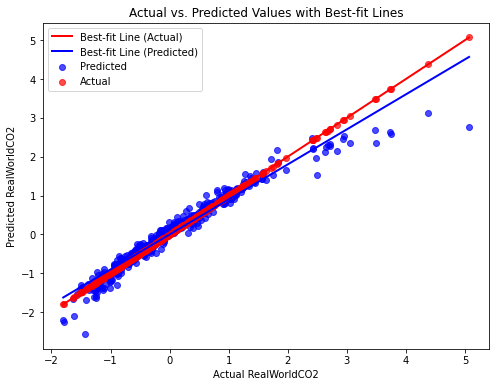

In [31]:
# Calculate the best-fit line coefficients for y_test using polyfit
coefficients_actual = np.polyfit(y_test, y_test, 1)  # Best-fit line for actual values
best_fit_line_actual = np.poly1d(coefficients_actual)

# Calculate the best-fit line coefficients for y_pred using polyfit
coefficients_predicted = np.polyfit(y_test, y_pred, 1)  # Best-fit line for predicted values
best_fit_line_predicted = np.poly1d(coefficients_predicted)

# Generate x values for the lines
x_line = np.linspace(min(y_test), max(y_test), 100)

# Generate y values for the lines using the best-fit line equations
y_line_actual = best_fit_line_actual(x_line)
y_line_predicted = best_fit_line_predicted(x_line)

# Create a scatter plot with the best-fit lines for actual and predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Predicted')
plt.scatter(y_test, y_test, color='red', alpha=0.7, label='Actual')
plt.plot(x_line, y_line_actual, color='red', linewidth=2, label='Best-fit Line (Actual)')
plt.plot(x_line, y_line_predicted, color='blue', linewidth=2, label='Best-fit Line (Predicted)')
plt.xlabel('Actual RealWorldCO2')
plt.ylabel('Predicted RealWorldCO2')
plt.title('Actual vs. Predicted Values with Best-fit Lines')
plt.legend()
plt.show()


Our results are pretty good but we can see that our data didn't accurately predict the data where CO2 was very high. This might be because we didn't have as many example of CO2 being high.

## Random Forest

We will now try Random Forst Model. Random Forest is a clever way to combine many decision trees to make accurate predictions. It works like a team of experts. Each expert (decision tree) gives their opinion, and the final decision on average opinion. It can tell you which factors are most important for making predictions.

In [32]:
# Create the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.001145333205929169
R-squared: 0.9989839566650114


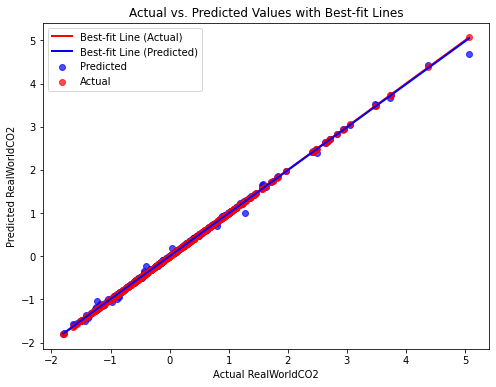

In [35]:
# Calculate the best-fit line coefficients for y_test using polyfit
coefficients_actual = np.polyfit(y_test, y_test, 1)  # Best-fit line for actual values
best_fit_line_actual = np.poly1d(coefficients_actual)

# Calculate the best-fit line coefficients for y_pred using polyfit
coefficients_predicted = np.polyfit(y_test, y_pred, 1)  # Best-fit line for predicted values
best_fit_line_predicted = np.poly1d(coefficients_predicted)

# Generate x values for the lines
x_line = np.linspace(min(y_test), max(y_test), 100)

# Generate y values for the lines using the best-fit line equations
y_line_actual = best_fit_line_actual(x_line)
y_line_predicted = best_fit_line_predicted(x_line)

# Create a scatter plot with the best-fit lines for actual and predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Predicted')
plt.scatter(y_test, y_test, color='red', alpha=0.7, label='Actual')
plt.plot(x_line, y_line_actual, color='red', linewidth=2, label='Best-fit Line (Actual)')
plt.plot(x_line, y_line_predicted, color='blue', linewidth=2, label='Best-fit Line (Predicted)')
plt.xlabel('Actual RealWorldCO2')
plt.ylabel('Predicted RealWorldCO2')
plt.title('Actual vs. Predicted Values with Best-fit Lines')
plt.legend()
plt.show()

This is a much better model and we see that most of the predictions are close to the actual data.

## Conclusion
We we're able to gain more insights to how different variables affect CO2 levels. We found MPG, vehicle type, weight, year and manufacturer are great predictors for emission levels. We found that a random forest model was much more accurate in fitting the data than a linear regression.